# YAHOO FINANCE: We will use yfinance, which is a popular Python library used for downloading historical market data from Yahoo Finance. Let's say we want to download the TESLA's stock price data. Here is how you would do it:

## First, you need to install the library if you haven't done so already. You can do this by running the following command in your notebook:

HELPFUL LINKS: https://algotrading101.com/learn/yfinance-guide/ ---
https://pypi.org/project/yfinance/ ---
https://finance.yahoo.com/lookup

# IMPORTS
## Then, you can use the following code to fetch the stock data:

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.metrics import mean_absolute_error
import yfinance as yf

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [ ]:
data = yf.download ("TSLA")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700
2023-06-09,249.070007,252.419998,242.020004,244.399994,244.399994,199882300
2023-06-12,247.940002,250.970001,244.589996,249.830002,249.830002,150337900


# Plot Data for Insight Gains

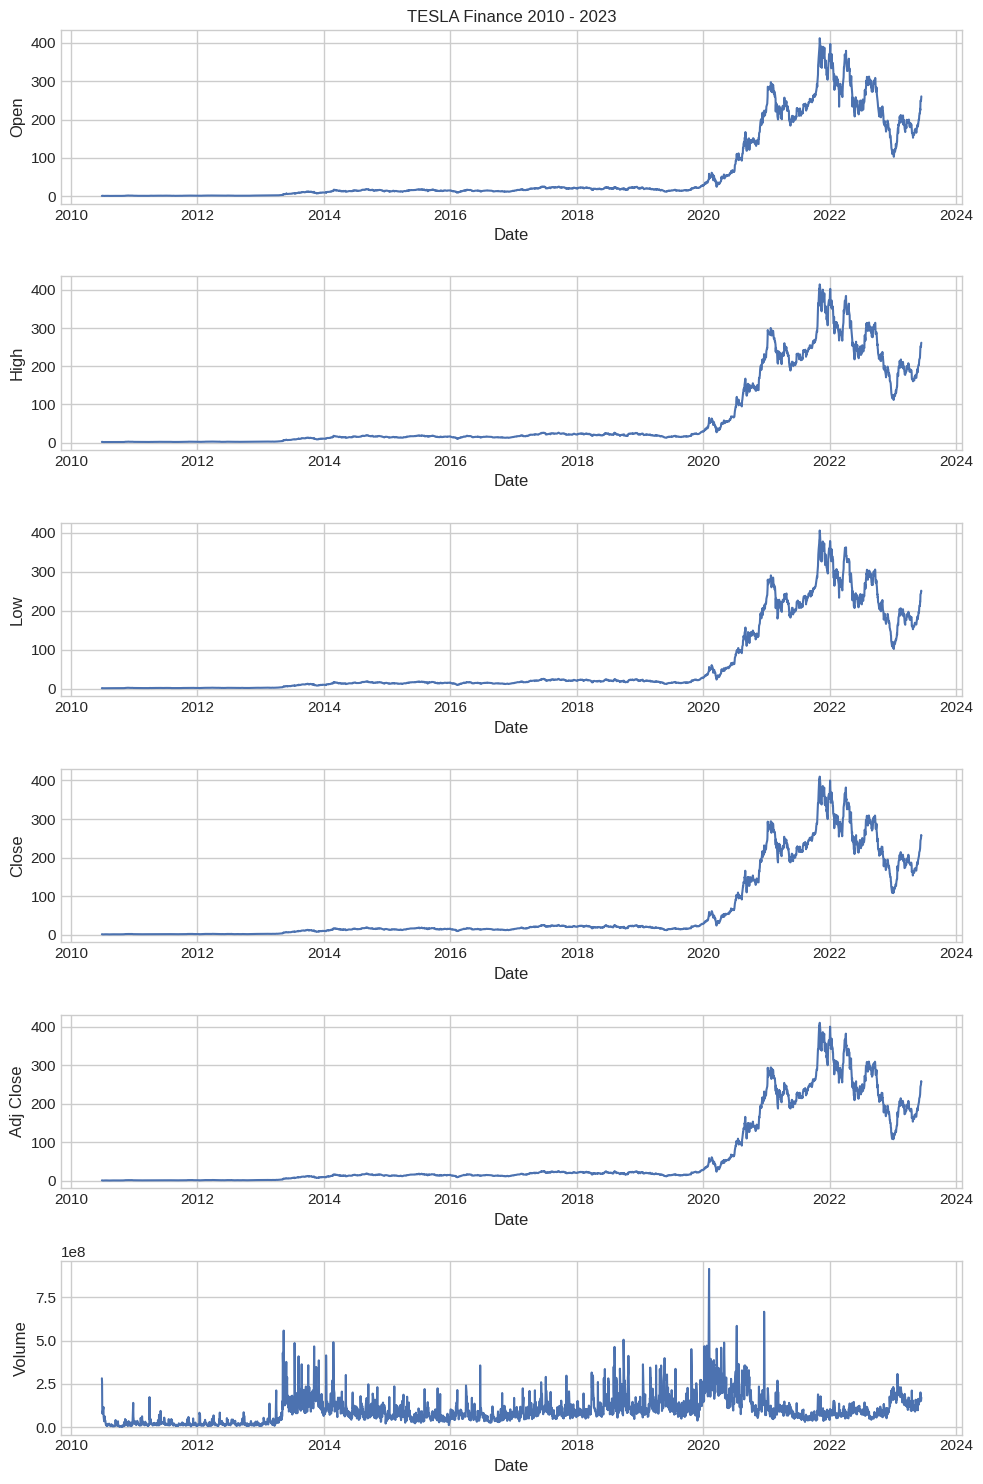

In [ ]:
def plot_columns(df):
  num_col = len(df.columns)
  fig, axes = plt.subplots(num_col, figsize=(10, 2.5*num_col))
  for i, column in enumerate(df.columns):
    sns.lineplot(ax=axes[i], data=df, x=df.index, y=column)
    axes[0].set_title('TESLA Finance 2010 - 2023')
  plt.tight_layout()
  plt.show()

plot_columns(data)

Text(0.5, 1.0, 'TESLA FINANCIAL TIME SERIES')

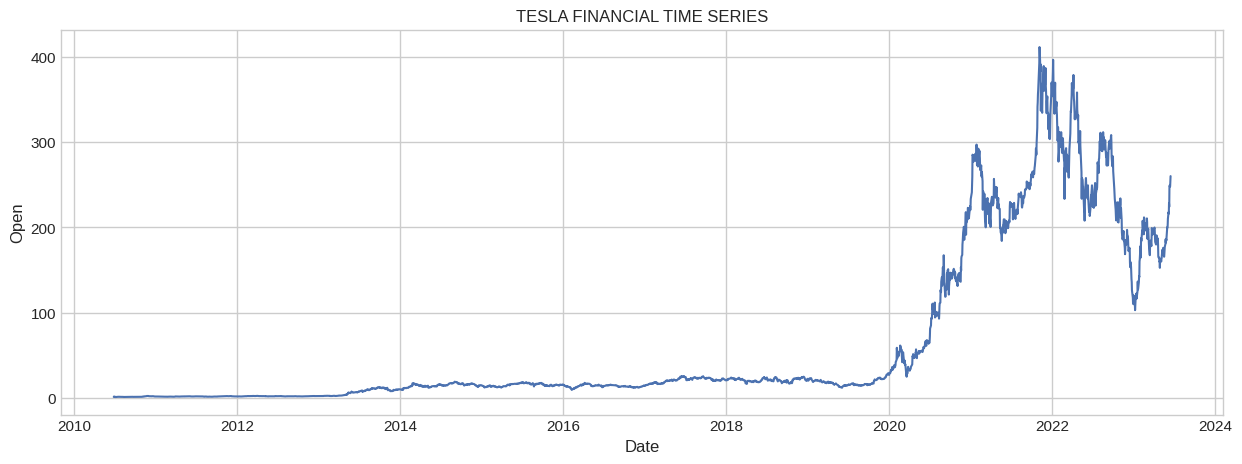

In [ ]:
plt.figure(figsize=(15,5))
sns.lineplot(data['Open'])
plt.title('TESLA FINANCIAL TIME SERIES')

# Data Pre-Processing
- We will Split train test data with a plit time of 2020-01-01

In [ ]:
split_time = '2020-01-01'
train_data = data.loc[:split_time]
test_data = data.loc[split_time:]

In [ ]:
train_open_data = train_data['Open']
valid_open_data = test_data['Open']

# SHOW SERIES
print(f'Train the Open Data \n{train_open_data.head()}\n')
print(f'Validation for the Open Data \n{valid_open_data.head()}\n')

Train the Open Data 
Date
2010-06-29    1.266667
2010-06-30    1.719333
2010-07-01    1.666667
2010-07-02    1.533333
2010-07-06    1.333333
Name: Open, dtype: float64

Validation for the Open Data 
Date
2020-01-02    28.299999
2020-01-03    29.366667
2020-01-06    29.364668
2020-01-07    30.760000
2020-01-08    31.580000
Name: Open, dtype: float64



# Now we can begin to forecast with Machine Learning

In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size = 30
train_set = window_dataset(train_open_data, window_size)
valid_set = window_dataset(valid_open_data, window_size)


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(train_open_data, window_size)
valid_set = window_dataset(valid_open_data, window_size)

# MODEL BUILDING
model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

# MODEL COMPILING
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# MODEL CALLBACKS
early_stopping = keras.callbacks.EarlyStopping(patience=10,
                                               restore_best_weights=True)
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))

# MODEL FITTING
history = model.fit(train_set, epochs=200,
                    validation_data=valid_set,
                    callbacks=[early_stopping, lr_schedule])


Epoch 1/200
74/74 [==============================] - 1s 9ms/step - loss: 6.9939 - mae: 7.4934 - val_loss: 99.7536 - val_mae: 100.2536 - lr: 1.0000e-06
Epoch 2/200
74/74 [==============================] - 0s 5ms/step - loss: 3.6670 - mae: 4.1516 - val_loss: 41.1038 - val_mae: 41.6023 - lr: 1.0798e-06
Epoch 3/200
74/74 [==============================] - 0s 5ms/step - loss: 0.6805 - mae: 1.0441 - val_loss: 12.3160 - val_mae: 12.8066 - lr: 1.1659e-06
Epoch 4/200
74/74 [==============================] - 0s 5ms/step - loss: 0.2629 - mae: 0.5352 - val_loss: 12.2493 - val_mae: 12.7399 - lr: 1.2589e-06
Epoch 5/200
74/74 [==============================] - 0s 5ms/step - loss: 0.2609 - mae: 0.5338 - val_loss: 12.2298 - val_mae: 12.7211 - lr: 1.3594e-06
Epoch 6/200
74/74 [==============================] - 1s 5ms/step - loss: 0.2601 - mae: 0.5331 - val_loss: 12.2164 - val_mae: 12.7061 - lr: 1.4678e-06
Epoch 7/200
74/74 [==============================] - 0s 5ms/step - loss: 0.2598 - mae: 0.5323 - val

# History insights

91


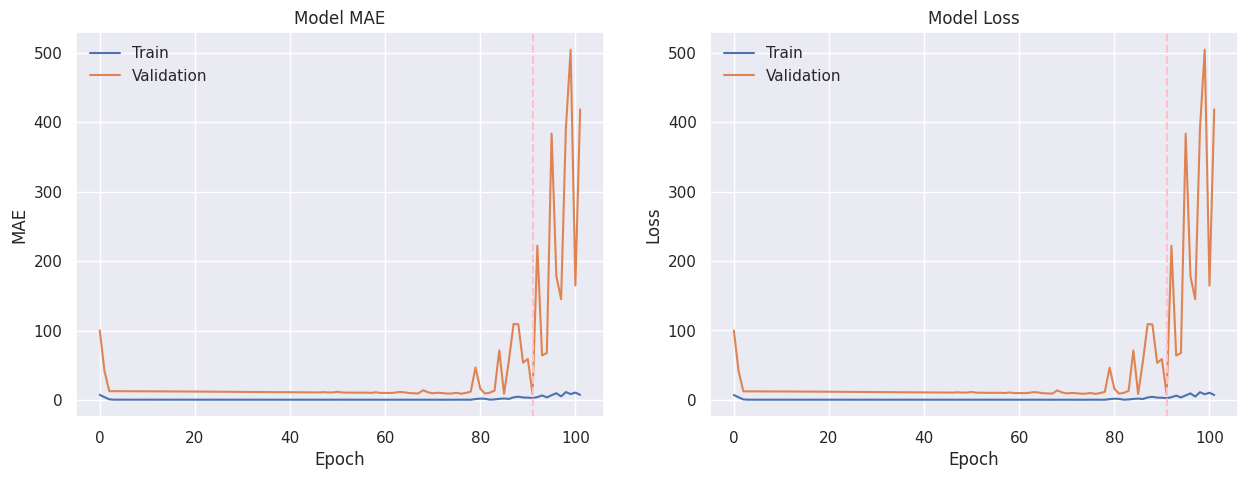

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_history(history):
  sns.set()
  fig, axs = plt.subplots(1,2,figsize=(15,5))
  axs[0].plot(history.history['mae'])
  axs[0].plot(history.history['val_mae'])
  axs[0].set_title('Model MAE')
  axs[0].set_ylabel('MAE')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_mae'])
  axs[0].axvline(x=best_epoch, color='pink', linestyle='--')

  axs[1].plot(history.history['loss'])
  axs[1].plot(history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Validation'], loc='upper left')

  best_epoch = np.argmin(history.history['val_loss'])
  print(best_epoch)
  axs[1].axvline(x=best_epoch, color='pink', linestyle='--')

  plt.show ()

plot_history (history)

- The Best Epoch is 73 it is Auto Restored Via Early Stopping Callback

In [ ]:
# Lets Forecast the Function
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
forecast = model_forecast(model, valid_open_data, window_size)[:, 0]
forecast

27/27 [==============================] - 0s 5ms/step


array([ 50.71668 ,  49.086452,  56.58235 ,  62.578194,  60.070015,
        65.13214 ,  60.176033,  54.225334,  54.018154,  52.21594 ,
        41.775043,  45.406437,  50.014988,  53.30997 ,  48.598373,
        47.895756,  41.839878,  43.192318,  37.87774 ,  34.08319 ,
        40.78491 ,  33.99985 ,  25.555073,  26.693855,  25.255718,
        21.430084,  28.830765,  28.420654,  29.983343,  34.27174 ,
        34.228527,  34.797474,  33.20168 ,  28.75961 ,  31.645214,
        33.382343,  34.012203,  34.21581 ,  37.054546,  37.599087,
        38.535236,  45.354897,  48.333424,  49.107746,  54.72739 ,
        49.949665,  49.37315 ,  51.933384,  48.91675 ,  48.41508 ,
        49.748318,  51.75235 ,  54.32176 ,  56.235676,  54.041714,
        50.22624 ,  50.26456 ,  51.934864,  50.56106 ,  54.177837,
        54.979237,  52.250122,  57.034077,  52.66273 ,  52.099186,
        54.96558 ,  51.835617,  51.339138,  56.590874,  53.370903,
        53.137554,  58.300117,  53.595882,  53.699535,  54.802

In [ ]:
# Forecase Dataframe
forecast_df = pd.DataFrame(forecast[:-1],
                           index=valid_open_data.index[window_size:
  window_size+len(forecast)],
                           columns=['Forecast'])

In [ ]:
# Lets Forecast Series
forecast_series = forecast_df['Forecast'].squeeze()
forecast_series

Date
2020-02-14     50.716679
2020-02-18     49.086452
2020-02-19     56.582352
2020-02-20     62.578194
2020-02-21     60.070015
                 ...    
2023-06-08    227.934082
2023-06-09    228.089096
2023-06-12    241.735443
2023-06-13    249.359436
2023-06-14    256.244507
Name: Forecast, Length: 839, dtype: float32

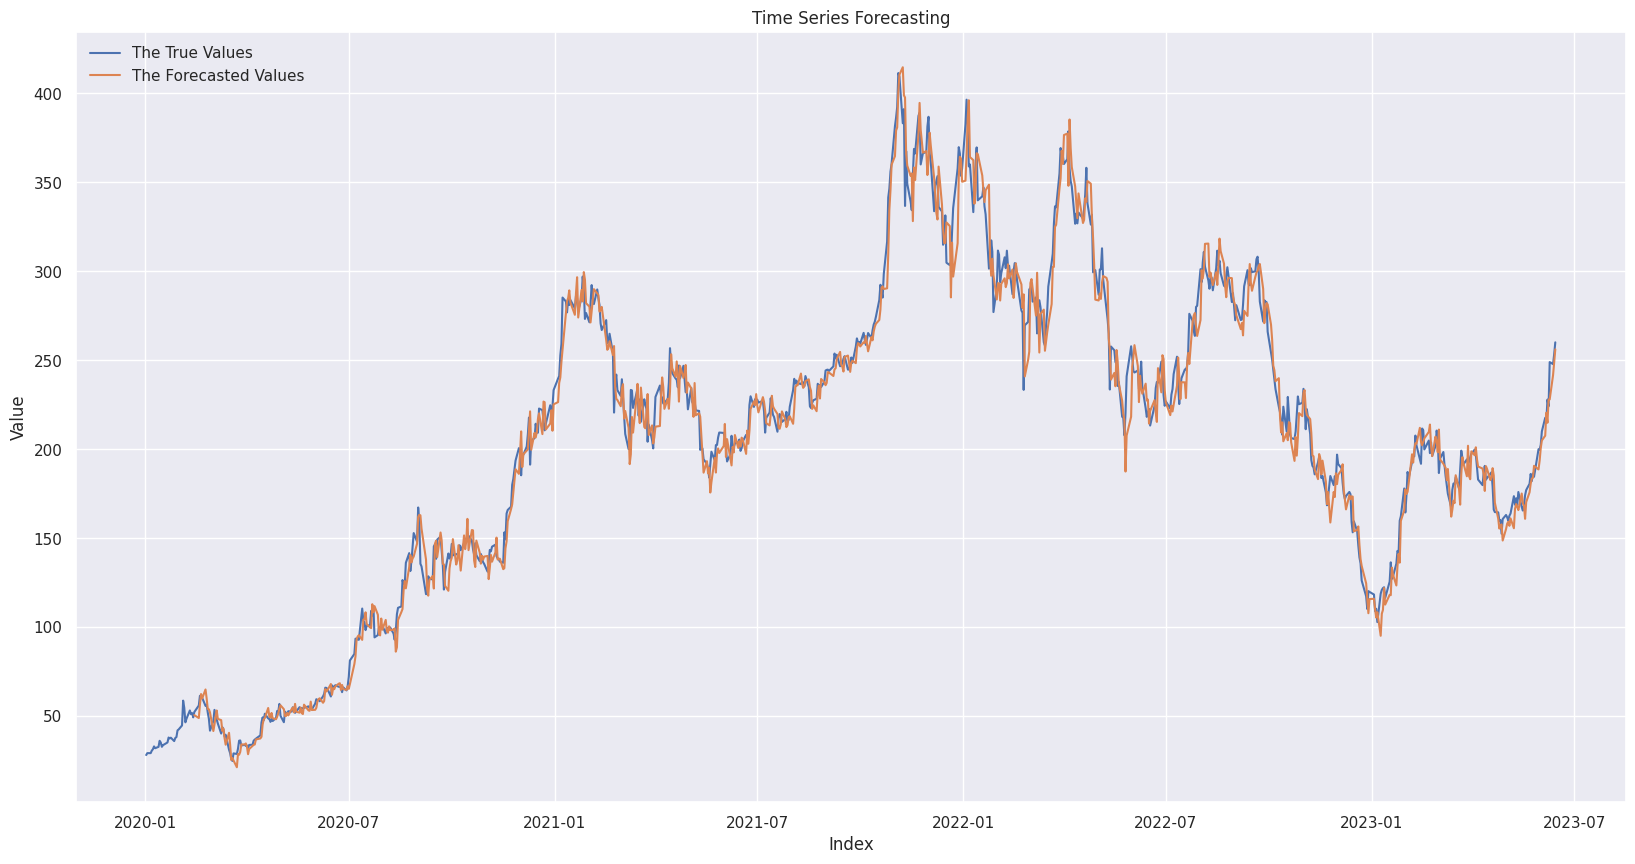

In [ ]:
# Ploting Real Values vs. Forecasted Values
def plot_predictions(y_true, y_pred):
  sns.set()
  plt.figure(figsize=(20,10))
  plt.plot(y_true, label='The True Values')
  plt.plot(y_pred, label='The Forecasted Values')
  plt.title('Time Series Forecasting')
  plt.ylabel('Value')
  plt.xlabel('Index')
  plt.legend(loc='upper left')
  plt.show

plot_predictions(valid_open_data, forecast_series)

In [ ]:
print(valid_open_data.head(10),'\n')
print(forecast_series.head(10))

Date
2020-01-02    28.299999
2020-01-03    29.366667
2020-01-06    29.364668
2020-01-07    30.760000
2020-01-08    31.580000
2020-01-09    33.139999
2020-01-10    32.119331
2020-01-13    32.900002
2020-01-14    36.284000
2020-01-15    35.317333
Name: Open, dtype: float64 

Date
2020-02-14    50.716679
2020-02-18    49.086452
2020-02-19    56.582352
2020-02-20    62.578194
2020-02-21    60.070015
2020-02-24    65.132141
2020-02-25    60.176033
2020-02-26    54.225334
2020-02-27    54.018154
2020-02-28    52.215939
Name: Forecast, dtype: float32


In [ ]:
print('Valid Data:',len(valid_open_data))
print('Forecasted Data:',len(forecast_series))

Valid Data: 869
Forecasted Data: 839


As can be observed, there is a difference of 30 between the lengths of the validation set and the forecasted values. This is due to the window size used during the forecasting process.
- To align the indices of the validation set and the forecasted values, we replaced the
validation data starting from the window size.

In [ ]:
valid_open_data = valid_open_data[window_size: ]
print('Valid Data:',len(valid_open_data))
print('Forecasted Data:',len(forecast_series))

Valid Data: 839
Forecasted Data: 839


In [ ]:
print(valid_open_data.head(10), '\n')
print(forecast_series.head(10))

Date
2020-02-14    52.481335
2020-02-18    56.106667
2020-02-19    61.566666
2020-02-20    60.796665
2020-02-21    60.465332
2020-02-24    55.933334
2020-02-25    56.599998
2020-02-26    52.166668
2020-02-27    48.666668
2020-02-28    41.980000
Name: Open, dtype: float64 

Date
2020-02-14    50.716679
2020-02-18    49.086452
2020-02-19    56.582352
2020-02-20    62.578194
2020-02-21    60.070015
2020-02-24    65.132141
2020-02-25    60.176033
2020-02-26    54.225334
2020-02-27    54.018154
2020-02-28    52.215939
Name: Forecast, dtype: float32


In [ ]:
print(f"Mean Absolute Error: {mean_absolute_error(valid_open_data, forecast_series).numpy()}")
# This text is reporting a statistical metric called Mean Absolute Error (MAE) which has a value of 7.898528575897217. MAE is a measure of the average magnitude of errors between the predicted and actual values in a regression model. It is calculated by taking the absolute difference between the predicted and actual values and then taking the average of those differences. The value of MAE indicates the average deviation between the predicted and actual values, with lower values indicating better predictive accuracy.

Mean Absolute Error: 8.291250228881836


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Mean Absolute Percentage Error: {mean_absolute_percentage_error(valid_open_data, forecast_series)}%")


Mean Absolute Percentage Error: 4.334782652422695%


The key difference between MAE and MAPE lies in the way they express prediction errors. While MAE provides the magnitude of the error in the same units as the original data, MAPE expresses the error as a percentage of the actual values. This makes MAPE more useful when you want to understand the relative error of the predictions, especially when dealing with datasets that have wide-ranging values.

However, both metrics have their limitations. MAE treats all errors equally, regardless of their direction (over or under prediction), while MAPE can become extremely large or undefined if the actual values contain zeros. Therefore, it's often beneficial to consider multiple error metrics when evaluating the performance of a predictive model.

# THOUGHTS
We achieve very good result using the MAE Task 7.89! Simple Neural Network is effective for simple forecasting tasks, but for more complex tasks, other architectural models like Recurrent Neural Networks (RNN), Long Short-Term Memory (LSTM), Gated Recurrent Unit (GRU), and Convolutional Neural Networks (CNN) can be applied.

Technical Terms:
- Mean Absolute Error (MAE): a metric used to measure the average magnitude of errors in a set of predictions, without considering their direction. It is computed as the average absolute difference between the actual and predicted values.
- Simple Neural Network: a type of neural network that consists of a single layer of input nodes, one or more hidden layers, and a single output layer. It is used for simple classification or regression tasks.
- Recurrent Neural Networks (RNN): a type of neural network that can handle sequential data by using feedback connections. It has a memory element that allows it to remember previous inputs and use them to inform future predictions.
- Long Short-Term Memory (LSTM): a type of RNN that is designed to avoid the vanishing gradient problem by using a gating mechanism to selectively remember or forget previous inputs.
- Gated Recurrent Unit (GRU): another type of RNN that simplifies the LSTM architecture by combining the forget and input gates into a single update gate.
- Convolutional Neural Networks (CNN): a type of neural network that is commonly used for image recognition tasks. It uses convolutional layers to extract features from the input data and pooling layers to reduce the dimensionality of the feature maps.


# Anomoly Detection in TESLA Finance
- INSTALL ADTK LIBRARY: The adtk library, short for "Anomaly Detection Toolkit," is a Python toolkit designed to provide a collection of time series anomaly detection algorithms. The library offers a wide range of modern and classical anomaly detection techniques such as ARIMA, Prophet, Seasonal Hybrid ESD, and more. Adtk is primarily built for time series analysis, data cleaning, and visualization. It can be used effectively in fields such as finance, smart- cities, and internet of things applications, where time series analysis is crucial. Adtk is open-source, so it's free to download and use. The adtk library is easy to learn and use for newcomers and experts alike. It comes with comprehensive documentation and practical examples, making it easy to apply to various use cases. Additionally, the versatile nature of this library, combined with its robustness, makes it an essential tool for implementation in machine learning applications.

In [ ]:
pip install adtk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#ADTK Imports
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import *

Outliners Detection using Boxplot
- Volumen will be delete since it is outside the common value range.
  -  Outliers are data points that are significantly different from the rest of the data. In this context, the text is suggesting that the variable "Volume" will be deleted because it falls outside of the common value range. This means that the volume data point is significantly different from the rest of the data and may be considered an outlier. By deleting it, the analysis can focus on the more typical data points.

<Axes: >

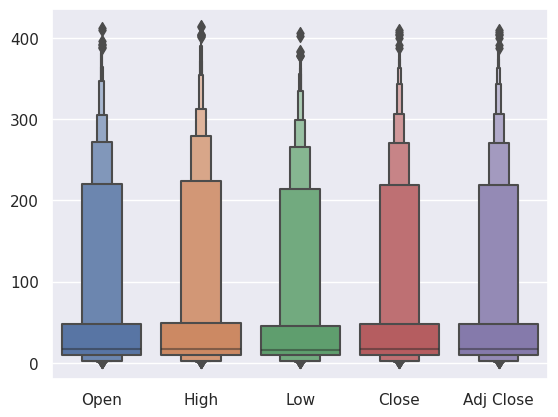

In [ ]:
del data['Volume']
sns.boxenplot(data)

 - Minimum Outliners Detected

In [ ]:
open_data = data['Open']
open_data

Date
2010-06-29      1.266667
2010-06-30      1.719333
2010-07-01      1.666667
2010-07-02      1.533333
2010-07-06      1.333333
                 ...    
2023-06-08    224.220001
2023-06-09    249.070007
2023-06-12    247.940002
2023-06-13    253.509995
2023-06-14    260.170013
Name: Open, Length: 3263, dtype: float64

In [ ]:
open_data.describe()

count    3263.000000
mean       63.036426
std        96.700362
min         1.076000
25%         9.687667
50%        16.549999
75%        47.159666
max       411.470001
Name: Open, dtype: float64

Threshold Detector
- Threshold detection is a commonly used technique for detecting anomalies in various applications. In threshold detection, a threshold value is set, and any readings that exceed this threshold value are considered anomalous. The success of this technique depends on setting an appropriate threshold value, which can be determined through statistical analysis or by domain experts. One common application of threshold detection is in network intrusion detection, where threshold value is set based on the normal network activity, and any traffic that exceeds the threshold is flagged as potentially malicious. Similarly, in industrial processes, threshold detection can be used to identify equipment that is operating outside of normal parameters, signaling the need for maintenance or repair.While threshold detection is a straightforward and easily implementable technique, it may not be suitable for all scenarios. For instance, if the underlying data distribution is too complex, it may be challenging to set an appropriate threshold value. Moreover, threshold detection suffers from issues of false positives and false negatives, which can lead to either over-detection or under-d
  - To choose the best high and low for threshold detection, it is important to consider the underlying data distribution and the specific application. One approach is to use statistical techniques such as mean, standard deviation, or quartiles to set the threshold value based on the normal behavior of the system or process. Alternatively, domain experts can provide insight into what range of values are expected and set the threshold accordingly.

  - It is also important to consider the consequences of false positives and false negatives in the specific application. False positives may result in unnecessary alerts or actions being taken, while false negatives may result in actual anomalous behavior going undetected. Balancing these considerations with the need for accurate detection can help in choosing the best high and low values for threshold detection.

Text(0.5, 1.0, 'Threshold Anomaly Detection TESLA')

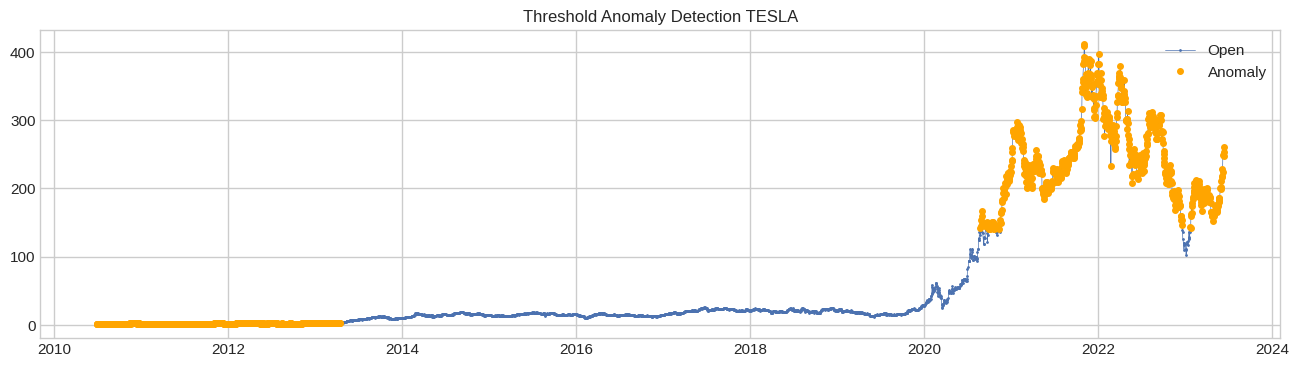

In [ ]:
Threshold_detector = ThresholdAD(low=3, high=140)
anomalies = Threshold_detector.detect(open_data)
plot(open_data,anomaly=anomalies, anomaly_color="orange", anomaly_tag='marker')
plt.title("Threshold Anomaly Detection TESLA")

# Quantile Detector
- A quantile detector is a statistical tool used to detect the presence of outliers or anomalies in a dataset. It works by dividing the dataset into equal parts based on the distribution of the data and then identifying any data points that fall outside of the expected range. The quantile detector is often used in fields such as finance, healthcare, and manufacturing to identify unusual patterns or behaviors that may require further investigation.
  - Anomoly Detection
  Compares time series values w. user-specific quantiles of historic data
    - Identifies time points as anomalous when values are beyond threshold

Text(0.5, 1.0, 'Quantile Anomalies Detection')

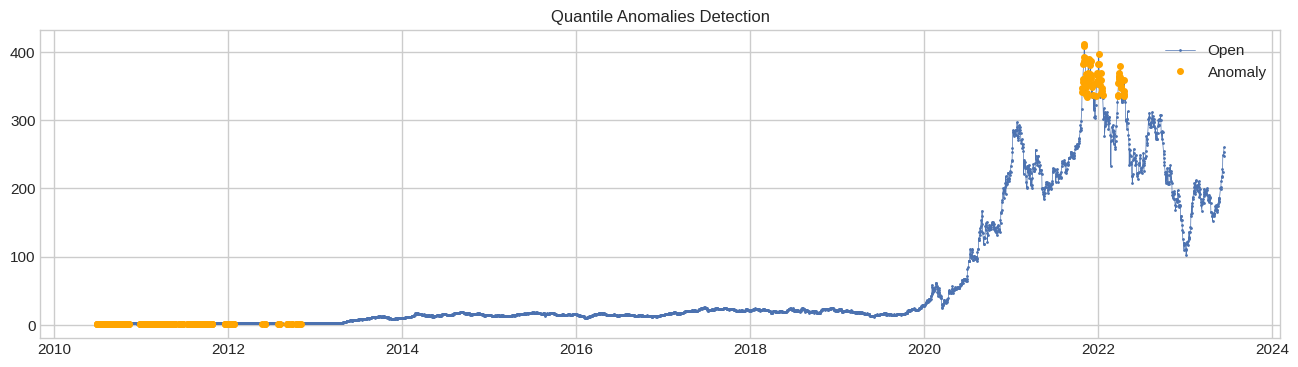

In [ ]:
quantile_detector = QuantileAD(low=0.1, high=0.98)
anomalies = quantile_detector.fit_detect(open_data)
plot(open_data,anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker")
plt.title("Quantile Anomalies Detection")

Inter Quartile Detector
  - The Inter Quartile Detector is a type of detector used to identify anomalies in data. It works by analyzing the inter-quartile range of historical data, which is the range between the 25th (1st) and 75th (3rd) percentiles of a dataset. Anomalies are detected if the values fall outside of this range. The inter-quartile range is a statistical measure that helps to identify the spread of data and is less sensitive to outliers compared to other measures such as the standard deviation.
    - Detector that detects anomaly based on inter-quartile range of historical data


Text(0.5, 1.0, 'Inter Quantile Range Anomaly Detection')

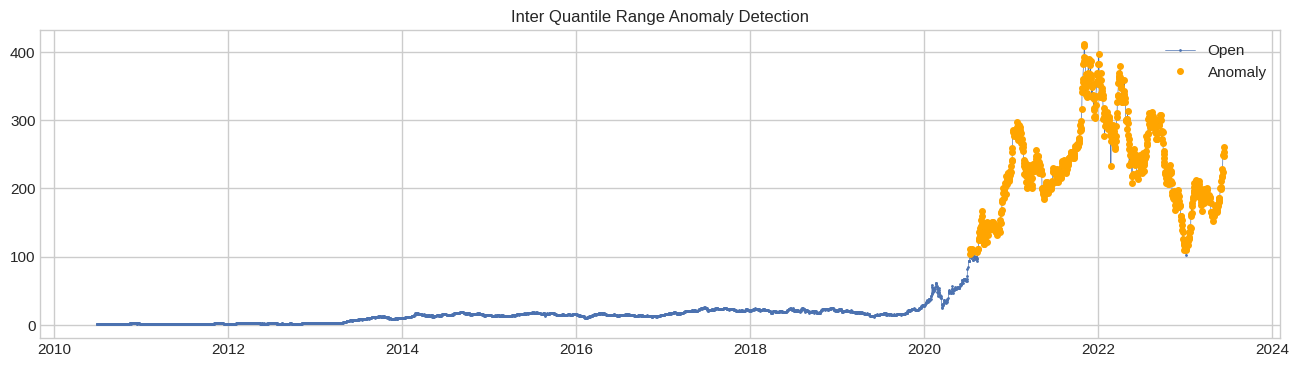

In [ ]:
iqr_detector = InterQuartileRangeAD(c=1.5)
anomalies = iqr_detector.fit_detect(open_data)
plot(open_data,anomaly=anomalies, anomaly_color="orange", anomaly_tag="marker")
plt.title("Inter Quantile Range Anomaly Detection")

# PERSISTENT DETECTOR
  - Detector that detects anomaly based on values in a preceding period.
  - This detector compares time series values with the values of their preceding time windows, and identifies a time point as anomalous if the change of value from its preceding average or median is anomalously large.

In [ ]:
persist_detector = PersistAD(c=15, side='positive')
anomalies = persist_detector.fit_detect(open_data)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

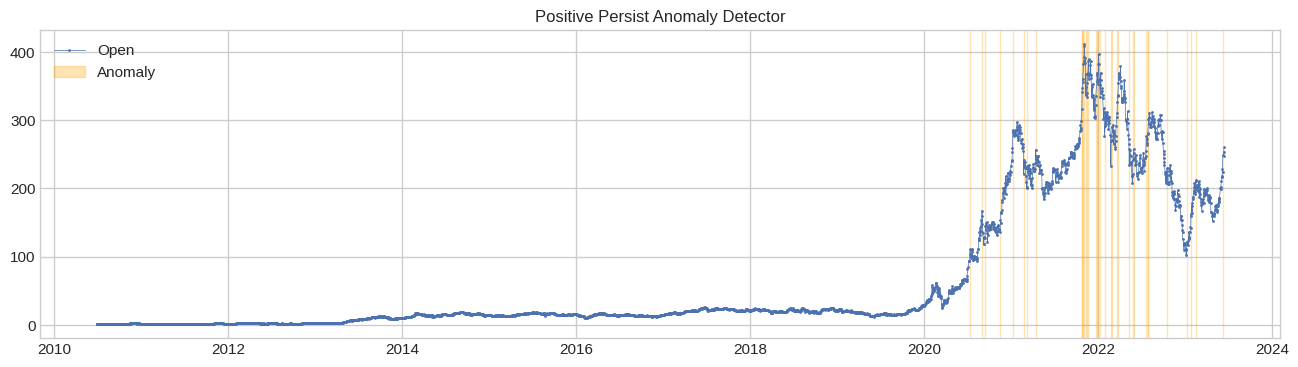

In [ ]:
plot(open_data,anomaly=anomalies, anomaly_color='orange')
plt.title('Positive Persist Anomaly Detector')

Text(0.5, 1.0, 'Positive Persist Anomaly Detector 2.0')

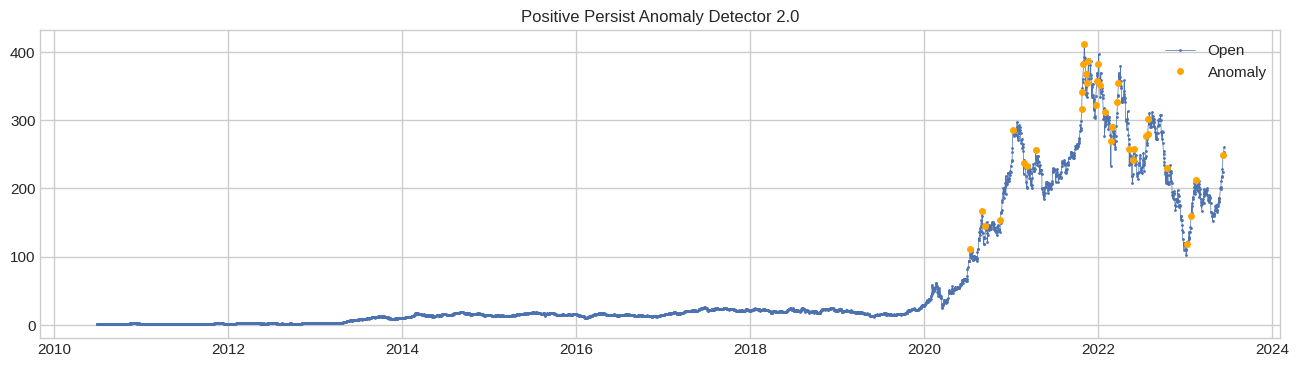

In [ ]:
plot(open_data,anomaly=anomalies, anomaly_color='orange', anomaly_tag='marker')
plt.title('Positive Persist Anomaly Detector 2.0')

In [ ]:
persist_detector = PersistAD(c=15, side='negative')
anomalies = persist_detector.fit_detect(open_data)

/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

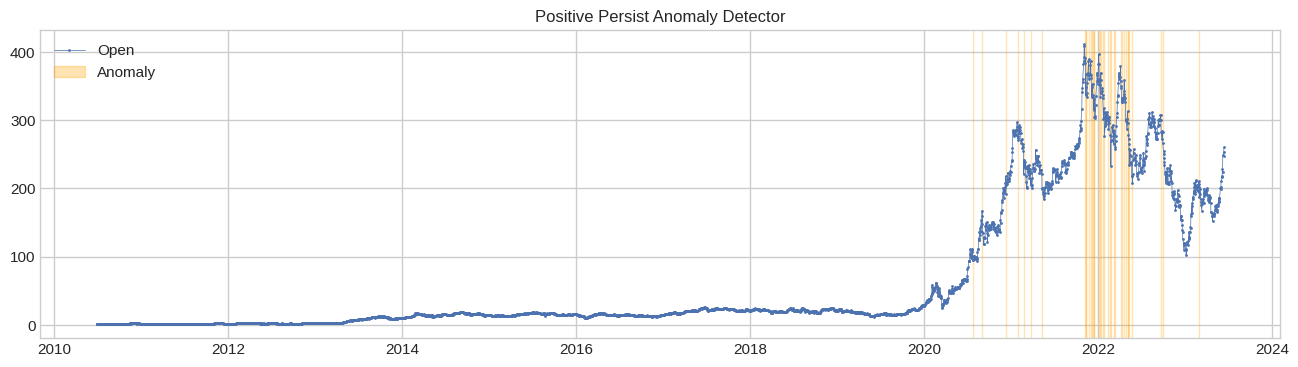

In [ ]:
plot(open_data,anomaly=anomalies, anomaly_color='orange')
plt.title('Positive Persist Anomaly Detector')

Text(0.5, 1.0, 'Positive Persist Anomaly Detector')

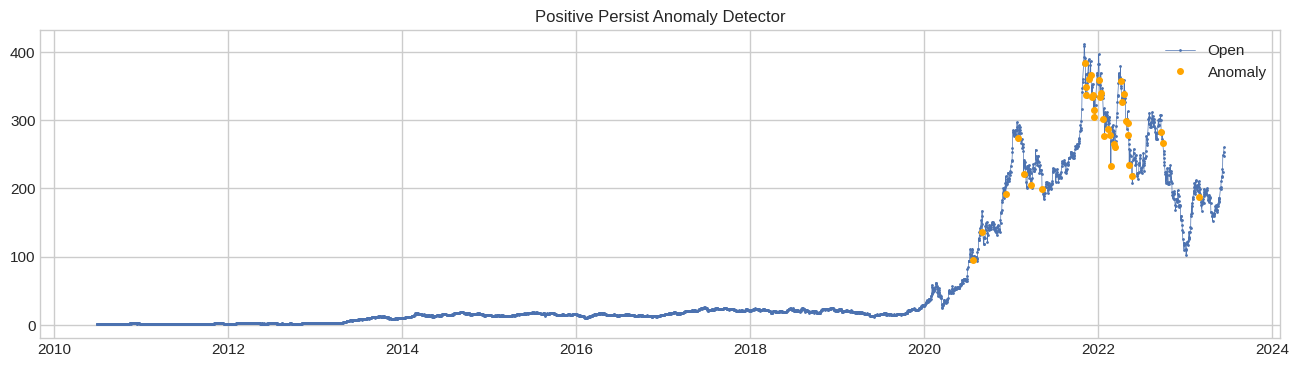

In [ ]:
plot(open_data,anomaly=anomalies, anomaly_color='orange', anomaly_tag='marker')
plt.title('Positive Persist Anomaly Detector')

# VOTALITY DETECTOR
- Shifts of volatility in the time series.
  - Volatility refers to the degree of variation in the values of a data set over time. The tool is used to detect shifts in this volatility, which may indicate changes in the underlying factors affecting the data.


/usr/local/lib/python3.10/dist-packages/adtk/data/_data.py:164: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for t, v in time_window_end_series.iteritems():  # type: pd.Timestamp, int


Text(0.5, 1.0, 'Volatility Anomaly Detection')

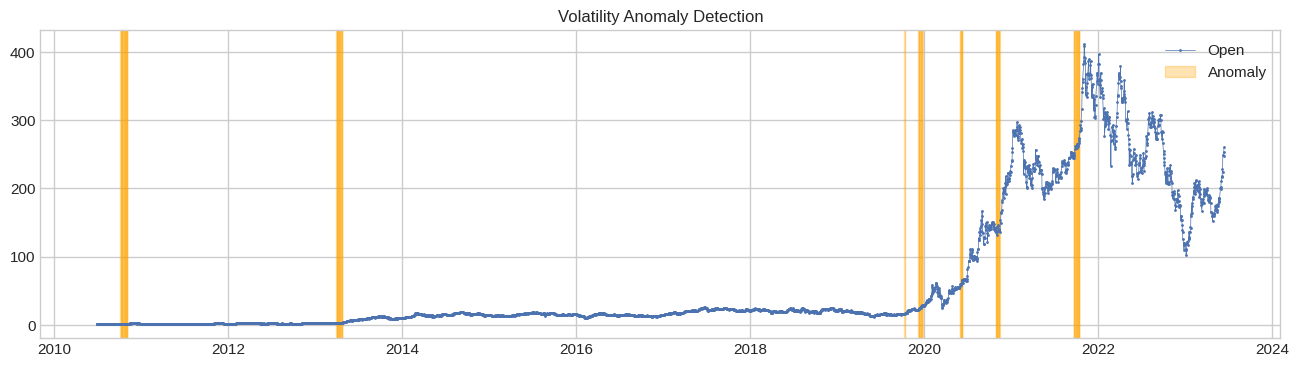

In [ ]:
volatility_detector = VolatilityShiftAD(c=6.0, side='positive', window=30)
anomalies = volatility_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='orange')
plt.title('Volatility Anomaly Detection')